In [ ]:
# https://youtu.be/jvZm8REF2KY
"""
Explanation of using RGB masks: https://youtu.be/sGAwx4GMe4E
https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. 
The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B

Use patchify....
Tile 1: 797 x 644 --> 768 x 512 --> 6 #closest size divisible by 256*256, then divide (crop) it into 256 patches
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12 EX: 1024/256=4, 768/256=3 ===>4*3=12 patches
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305

Total 1305 patches of size 256x256
"""

In [8]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm  #pretrained models
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

#### !pip install patchify, segmentation-models

In [9]:
root_directory = 'Semantic segmentation dataset/'

patch_size = 256

#### Extracting 256 by 256 patches by 1) cropping 2)patchifying

In [10]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)


Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_004.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_005.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_006.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_007.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_008.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_009.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/T

In [12]:
print(path)

Semantic segmentation dataset/Tile 8\masks


#### Similarly extracting patches from masks 

In [11]:
#Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_003.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_004.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_005.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_006.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_007.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_008.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_009.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_

In [13]:
#converting lists into array:  1305-> (1305, 256, 256, 3)
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#### Sanity check 

In [ ]:
# Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

### Now, lets get the RGB values for all the labels represented in HEX

In [18]:
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098 (hex-code for building data)
3C = 3*16 + 12 = 60 ->R
10 = 1*16 + 0 = 16 ->G
98 = 9*16 + 8 = 152 ->B
"""

'\nRGB to HEX: (Hexadecimel --> base 16)\nThis number divided by sixteen (integer division; ignoring any remainder) gives \nthe first hexadecimal digit (between 0 and F, where the letters A to F represent \nthe numbers 10 to 15). The remainder gives the second hexadecimal digit. \n0-9 --> 0-9\n10-15 --> A-F\nExample: RGB --> R=201, G=, B=\nR = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)\nCalculating RGB from HEX: #3C1098\n3C = 3*16 + 12 = 60\n10 = 1*16 + 0 = 16\n98 = 9*16 + 8 = 152\n'

In [19]:
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)

60


In [20]:
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


In [23]:
print("[R  G  B] code for Building is", Building)

[R  G  B] code for Building is [ 60  16 152]


In [24]:
label = single_patch_mask

In [26]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [27]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)


In [28]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


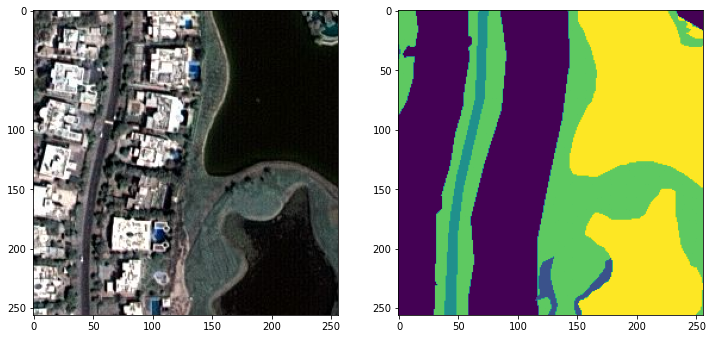

In [31]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

#### So far our labels are not on-hot encoded, instead they're integer encoded, means 0,1,2,3,4,5
##### Now, convert it into one-hot (imp for multiclass problems)

In [33]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [35]:
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) #similar to IoU
focal_loss = sm.losses.CategoricalFocalLoss()  #is useful for dataset with easy vs tuff classes
total_loss = dice_loss + (1 * focal_loss)  


In [36]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [37]:
IMG_HEIGHT

256

In [39]:
from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [40]:
model.input_shape

(None, 256, 256, 3)

In [ ]:
"""history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)
"""

In [43]:
import tensorflow as tf
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_satellite.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='satellite_logs')]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=100, callbacks=callbacks)

####################################

Epoch 1/100
66/66 [==============================] - 33s 281ms/step - loss: 1.0070 - accuracy: 0.4665 - jacard_coef: 0.2137 - val_loss: 0.9751 - val_accuracy: 0.6777 - val_jacard_coef: 0.3385
Epoch 2/100
66/66 [==============================] - 4s 66ms/step - loss: 0.9678 - accuracy: 0.6800 - jacard_coef: 0.4152 - val_loss: 0.9713 - val_accuracy: 0.6502 - val_jacard_coef: 0.4204
Epoch 3/100
66/66 [==============================] - 4s 65ms/step - loss: 0.9514 - accuracy: 0.7394 - jacard_coef: 0.4858 - val_loss: 0.9660 - val_accuracy: 0.6640 - val_jacard_coef: 0.4185
Epoch 4/100
66/66 [==============================] - 4s 64ms/step - loss: 0.9426 - accuracy: 0.7580 - jacard_coef: 0.5236 - val_loss: 0.9511 - val_accuracy: 0.7346 - val_jacard_coef: 0.5040
Epoch 5/100
66/66 [==============================] - 4s 64ms/step - loss: 0.9389 - accuracy: 0.7769 - jacard_coef: 0.5519 - val_loss: 0.9582 - val_accuracy: 0.7230 - val_jacard_coef: 0.5001
Epoch 6/100
66/66 [=============================

In [ ]:
#Minmaxscaler
#With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss
#With focal loss only, after 100 epochs val jacard is: 0.62  (Mean IoU: 0.6)            
#With dice loss only, after 100 epochs val jacard is: 0.74 (Reached 0.7 in 40 epochs)
#With dice + 5 focal, after 100 epochs val jacard is: 0.711 (Mean IoU: 0.611)
##With dice + 1 focal, after 100 epochs val jacard is: 0.75 (Mean IoU: 0.62)
#Using categorical crossentropy as loss: 0.71

##With calculated weights in Dice loss.    
#With dice loss only, after 100 epochs val jacard is: 0.672 (0.52 iou)


##Standardscaler 
#Using categorical crossentropy as loss: 0.677

In [54]:
model.save('satellite_model')

INFO:tensorflow:Assets written to: satellite_model\assets


### TRY ANOTHE MODEL - WITH PRETRINED WEIGHTS 

In [ ]:
#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [ ]:
# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())

In [ ]:
history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))


In [ ]:
#Minmaxscaler
#With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss
#With focal loss only, after 100 epochs val jacard is:               
#With dice + 5 focal, after 100 epochs val jacard is: 0.73 (reached 0.71 in 40 epochs. So faster training but not better result. )
##With dice + 1 focal, after 100 epochs val jacard is:   
    ##Using categorical crossentropy as loss: 0.755 (100 epochs)
#With calc. weights supplied to model.fit: 
 
#Standard scaler
#Using categorical crossentropy as loss: 0.74

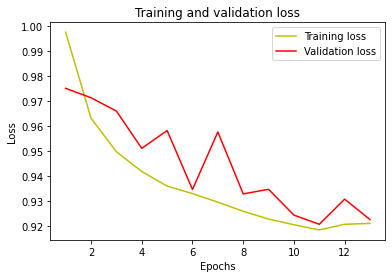

In [50]:
###########################################################
#plot the training and validation accuracy and loss at each epoch
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

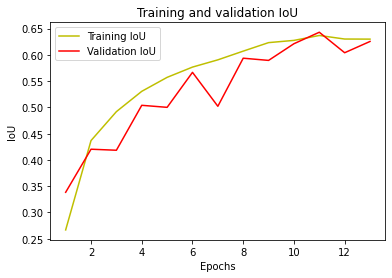

In [52]:
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [69]:
from tensorflow.keras.models import load_model
model = load_model("satellite_model",
                   custom_objects={'dice_loss_plus_2focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

ValueError: Unknown loss function: dice_loss_plus_1focal_loss

In [64]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from tensorflow.keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5236185


Mean IoU = 0.5236185


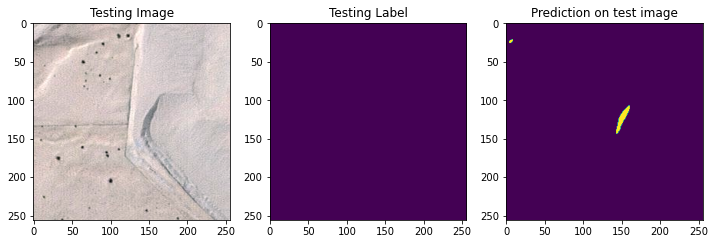

In [68]:
#Using built in keras function for IoU
from tensorflow.keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()